### ⚙️ Cell 1: Imports & Configuration

First, we import necessary libraries and set up the device (GPU/CPU). **bold text**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
# Import necessary modules from torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
# Import necessary modules from sklearn for metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import time
import copy
from collections import Counter

# 1. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# 2. Config
# Corrected path to the root folder containing 'train', 'valid', and 'test'
DATA_DIR_BASE = "/content/drive/MyDrive/Dataset2"
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"✅ Configuration set. Base Data Directory: {DATA_DIR_BASE}")

✅ Using device: cuda
✅ Configuration set. Base Data Directory: /content/drive/MyDrive/Dataset2


**Cell - 2 Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 📂 Cell 3: Data Loading & Transforms

We define image transformations (resize, normalize) and load the folders. **bold text**

In [ ]:
DATA_DIR_BASE = "/content/drive/MyDrive/Dataset2" #YOUR CORRECT PATH

# Define Transforms
# MobileNet typically expects normalization with these specific mean/std values
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Define the exact directories for each split
split_dirs = {
    'train': os.path.join(DATA_DIR_BASE, 'train'),
    'valid': os.path.join(DATA_DIR_BASE, 'valid'),
    'test': os.path.join(DATA_DIR_BASE, 'test'),
}

# Load Datasets using the correct directory paths
image_datasets = {x: datasets.ImageFolder(split_dirs[x], data_transforms[x])
                  for x in ['train', 'valid', 'test']}

# Create DataLoaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x == 'train'), num_workers=2)
               for x in ['train', 'valid', 'test']}

# Get sizes and class names for reference
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes
print(f"Class Mapping: {image_datasets['train'].class_to_idx}")


print(f"✅ Data loading successful from {DATA_DIR_BASE}")
print(f"✅ Classes found: {class_names}")
print(f"✅ Dataset sizes: {dataset_sizes}")

Class Mapping: {'fake': 0, 'real': 1}
✅ Data loading successful from /content/drive/MyDrive/Dataset2
✅ Classes found: ['fake', 'real']
✅ Dataset sizes: {'train': 6920, 'valid': 1973, 'test': 987}


### 📊 Cell 4: Dataset Visualization & Distribution

This cell calculates the counts for Real vs. Fake images and creates the 3 specific charts you requested. **bold text**

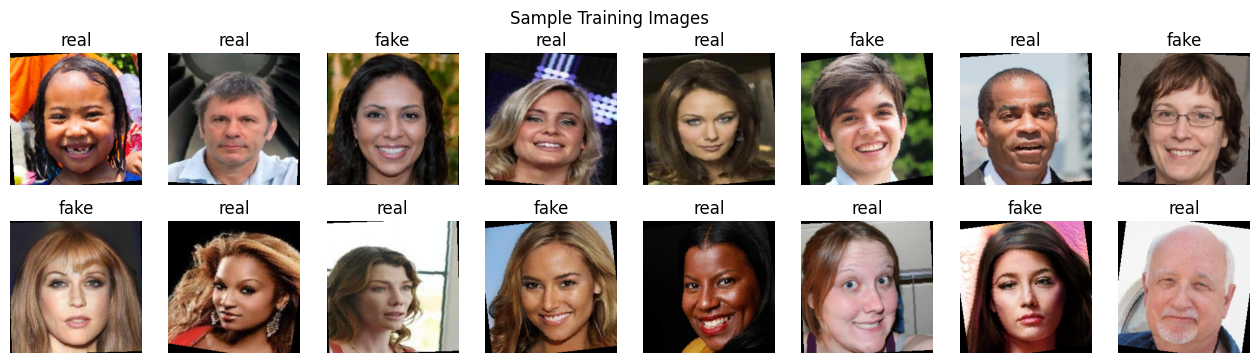

Class Mapping: {'fake': 0, 'real': 1}


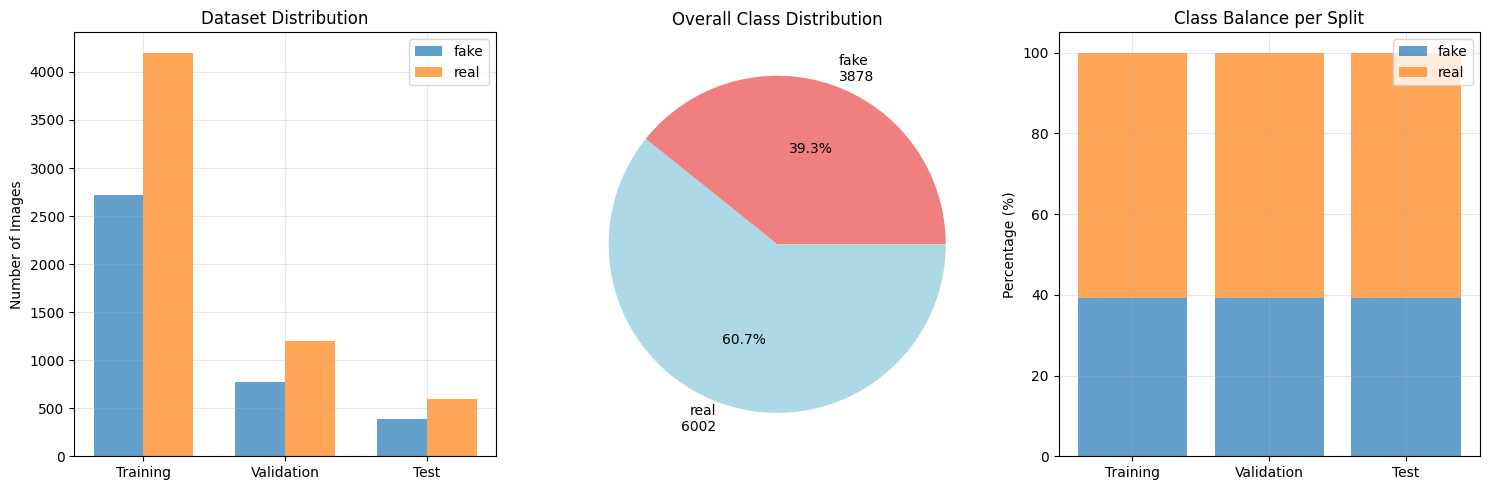

In [ ]:
# 1. Visualize Sample Images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Undo normalization for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Plot 2x8 grid
plt.figure(figsize=(16, 4))
for i in range(16):
    plt.subplot(2, 8, i+1)
    imshow(inputs[i], title=class_names[classes[i]])
    plt.axis('off')
plt.suptitle("Sample Training Images")
plt.show()

# 2. Dataset Distribution Plots
# We need to count files manually or iterate quickly to get exact counts per class
def get_class_counts(dataset):
    # Assumes targets are 0 and 1
    targets = dataset.targets
    counts = Counter(targets)
    return counts[0], counts[1] # Assuming 0=Fake, 1=Real (or vice versa depending on folder order)

# Note: Check your class_to_idx to confirm which is 0 and 1.
# Usually folder names determine alphabetical order.
print("Class Mapping:", image_datasets['train'].class_to_idx)

train_c = get_class_counts(image_datasets['train'])
val_c = get_class_counts(image_datasets['valid'])
test_c = get_class_counts(image_datasets['test'])

splits = ['Training', 'Validation', 'Test']
# Assuming class 0 is the first one in class_names and 1 is the second
label_0 = class_names[0] # e.g., 'Fake'
label_1 = class_names[1] # e.g., 'Real'

group_0_counts = [train_c[0], val_c[0], test_c[0]]
group_1_counts = [train_c[1], val_c[1], test_c[1]]

plt.figure(figsize=(15,5))

# Bar chart
plt.subplot(1,3,1)
x = np.arange(len(splits)); width = 0.35
plt.bar(x - width/2, group_0_counts, width, label=label_0, alpha=0.7)
plt.bar(x + width/2, group_1_counts, width, label=label_1, alpha=0.7)
plt.xticks(x, splits); plt.ylabel('Number of Images'); plt.title('Dataset Distribution'); plt.legend(); plt.grid(alpha=0.3)

# Pie chart overall
plt.subplot(1,3,2)
total_0 = sum(group_0_counts)
total_1 = sum(group_1_counts)
plt.pie([total_0, total_1], labels=[f'{label_0}\n{total_0}', f'{label_1}\n{total_1}'], autopct='%1.1f%%', colors=['lightcoral','lightblue'])
plt.title('Overall Class Distribution')

# Class balance per split (stacked percentage)
plt.subplot(1,3,3)
# Calculate percentages
total_per_split = [g0 + g1 for g0, g1 in zip(group_0_counts, group_1_counts)]
p_0 = [c/t*100 if t>0 else 0 for c, t in zip(group_0_counts, total_per_split)]
p_1 = [c/t*100 if t>0 else 0 for c, t in zip(group_1_counts, total_per_split)]

plt.bar(splits, p_0, label=label_0, alpha=0.7)
plt.bar(splits, p_1, bottom=p_0, label=label_1, alpha=0.7)
plt.ylabel('Percentage (%)'); plt.title('Class Balance per Split'); plt.legend(); plt.grid(alpha=0.3)

plt.tight_layout(); plt.show()

### 🏗️ Cell 5: Define Models (MobileNetV2 & Custom CNN)

Here we define the two architectures in PyTorch. **bold text**

In [ ]:
# 1. Custom CNN Model
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1) # Output 1 logit for binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 2. MobileNetV2 Model
def create_mobilenet():
    model = models.mobilenet_v2(pretrained=True)

    # Freeze early layers
    for param in model.parameters():
        param.requires_grad = False

    # Replace the classifier head
    # MobileNetV2 classifier input features is 1280
    model.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(1280, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128), # Batch Norm added as requested
        nn.Dropout(0.2),
        nn.Linear(128, 1)
    )
    return model

# Initialize models
model_cnn = CustomCNN().to(device)
model_mobilenet = create_mobilenet().to(device)

# Helper to print summary (like Keras)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Custom CNN Trainable Parameters: {count_parameters(model_cnn):,}")
print(f"✅ MobileNetV2 Trainable Parameters: {count_parameters(model_mobilenet):,}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 80.2MB/s]


✅ Custom CNN Trainable Parameters: 51,605,569
✅ MobileNetV2 Trainable Parameters: 164,353


### 🔄 Cell 6: Training Function with Hyperparameter Tuning

We create a flexible training function to handle different learning rates. **bold text**

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10, patience=3):
    """
    Trains and validates a PyTorch model.
    Patience is used for early stopping based on validation loss.
    """
    since = time.time()

    # Initialize history dictionary using 'valid' key
    history = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Iterate through 'train' and 'valid' phases
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get data from the correct dataloader (dataloaders['train'] or dataloaders['valid'])
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1) # Ensure labels are float and match output shape

                optimizer.zero_grad()

                # Forward pass and parameter update (only in train phase)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.sigmoid(outputs) > 0.5 # Convert logits to binary prediction

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Store results using the correct phase key (e.g., 'valid_loss')
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Early Stopping & Best Model Save (uses 'valid' phase)
            if phase == 'valid':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_counter = 0
                else:
                    patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid Loss: {best_loss:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

# --- Hyperparameter Tuning & Execution ---
# Note: MobileNetV2 and CustomCNN models (model_mobilenet, model_cnn) must be defined in Cell 4
# and the device must be defined in Cell 1.

learning_rates = [1e-3, 1e-4]
trained_models = {}
histories = {}
criterion = nn.BCEWithLogitsLoss()

# 1. Train Custom CNN
print("\n🚀 Training Custom CNN...")
# Using 1e-4 for the example, as 1e-3 is often too high initially
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.0001)
model_cnn, hist_cnn = train_model(model_cnn, criterion, optimizer_cnn, num_epochs=15)
trained_models['cnn'] = model_cnn
histories['cnn'] = hist_cnn

# 2. Train MobileNet
print("\n🚀 Training MobileNetV2...")
optimizer_mob = optim.Adam(model_mobilenet.parameters(), lr=0.0001)
model_mob, hist_mob = train_model(model_mobilenet, criterion, optimizer_mob, num_epochs=15)
trained_models['mobilenet'] = model_mob
histories['mobilenet'] = hist_mob


🚀 Training Custom CNN...
Epoch 1/15
----------
Train Loss: 0.5309 Acc: 0.7186
Valid Loss: 0.4174 Acc: 0.7993
Epoch 2/15
----------
Train Loss: 0.4436 Acc: 0.7738
Valid Loss: 0.3830 Acc: 0.8049
Epoch 3/15
----------
Train Loss: 0.4095 Acc: 0.7918
Valid Loss: 0.3684 Acc: 0.8135
Epoch 4/15
----------
Train Loss: 0.3853 Acc: 0.8062
Valid Loss: 0.3647 Acc: 0.8094
Epoch 5/15
----------
Train Loss: 0.3734 Acc: 0.8132
Valid Loss: 0.3373 Acc: 0.8241
Epoch 6/15
----------
Train Loss: 0.3516 Acc: 0.8289
Valid Loss: 0.3409 Acc: 0.8287
Epoch 7/15
----------
Train Loss: 0.3390 Acc: 0.8376
Valid Loss: 0.3296 Acc: 0.8378
Epoch 8/15
----------
Train Loss: 0.3199 Acc: 0.8496
Valid Loss: 0.3169 Acc: 0.8500
Epoch 9/15
----------
Train Loss: 0.3087 Acc: 0.8571
Valid Loss: 0.3315 Acc: 0.8424
Epoch 10/15
----------
Train Loss: 0.2980 Acc: 0.8660
Valid Loss: 0.3042 Acc: 0.8505
Epoch 11/15
----------
Train Loss: 0.2789 Acc: 0.8725
Valid Loss: 0.3401 Acc: 0.8459
Epoch 12/15
----------
Train Loss: 0.2672 Acc: 0

### Cell **7**

In [ ]:
import torch
import os

# --- Configuration ---
# Define a directory to save the model weights
SAVE_DIR = "/content/drive/MyDrive/Model_Weights"  # Adjust this path if needed
os.makedirs(SAVE_DIR, exist_ok=True)

# --- Models and their corresponding keys in trained_models dictionary ---
models_to_save = {
    "CustomCNN": trained_models['cnn'],
    "MobileNetV2": trained_models['mobilenet']
}

# --- Loop through each model and save its weights ---
for model_name, model_obj in models_to_save.items():
    # Define the filename for this model
    model_filename = f"{model_name}_DeepFake_Detector_best.pth"
    save_path = os.path.join(SAVE_DIR, model_filename)

    # Save the model's state dictionary
    try:
        torch.save(model_obj.state_dict(), save_path)
        print(f"✅ Successfully saved {model_name} weights to: {save_path}")
    except Exception as e:
        print(f"❌ Error saving {model_name} weights: {e}")


✅ Successfully saved CustomCNN weights to: /content/drive/MyDrive/Model_Weights/CustomCNN_DeepFake_Detector_best.pth
✅ Successfully saved MobileNetV2 weights to: /content/drive/MyDrive/Model_Weights/MobileNetV2_DeepFake_Detector_best.pth


### 📉 Cell 8: Plot Learning Curves

This plots the Accuracy and Loss over epochs for both models. **bold text**

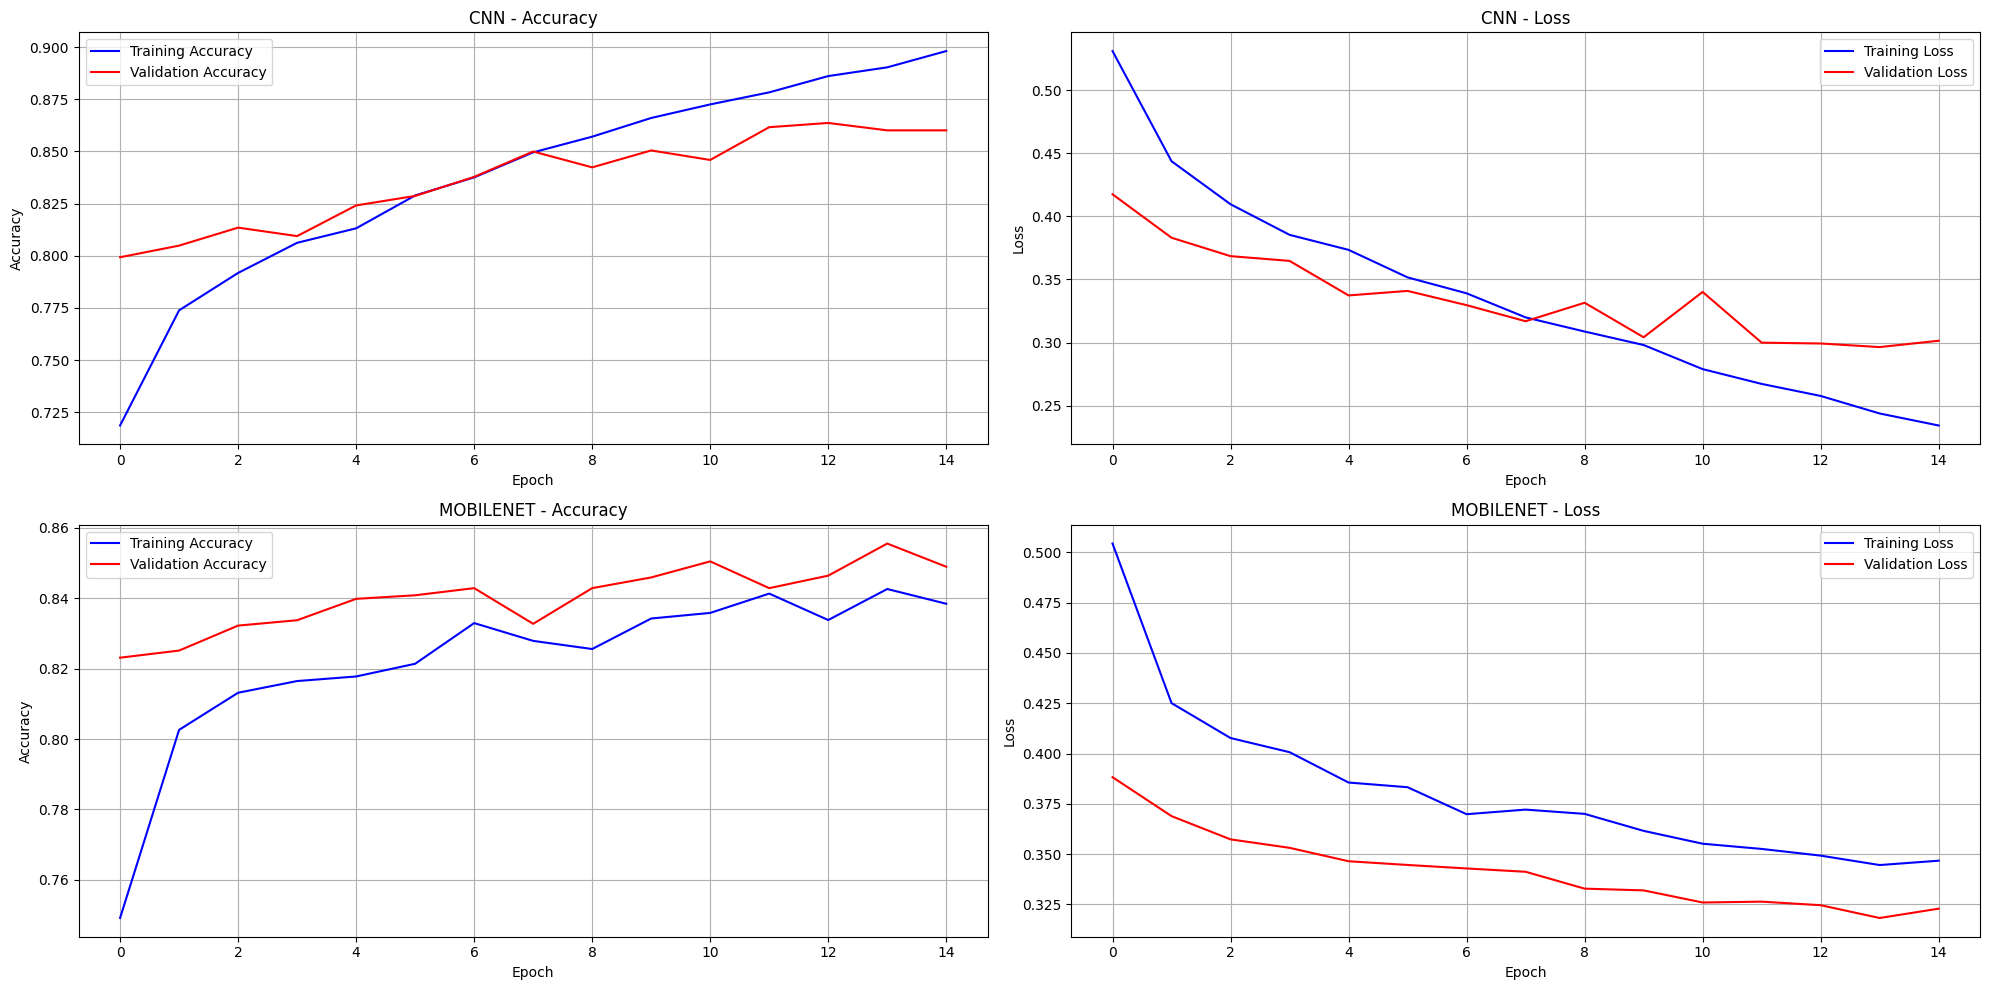

In [ ]:
plt.figure(figsize=(20, 10))

for idx, model_name in enumerate(histories.keys()):
    history = histories[model_name]

    # Accuracy Plot
    plt.subplot(2, 2, idx * 2 + 1)
    plt.plot(history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(history['valid_acc'], 'r-', label='Validation Accuracy')
    plt.title(f'{model_name.upper()} - Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

    # Loss Plot
    plt.subplot(2, 2, idx * 2 + 2)
    plt.plot(history['train_loss'], 'b-', label='Training Loss')
    plt.plot(history['valid_loss'], 'r-', label='Validation Loss')
    plt.title(f'{model_name.upper()} - Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

### 🧪 Cell 9: Evaluation & Confusion Matrix

This cell runs prediction on the Test Set and generates the full evaluation report (Confusion Matrix, ROC, etc.). **bold text**

Evaluating cnn...
Evaluating mobilenet...


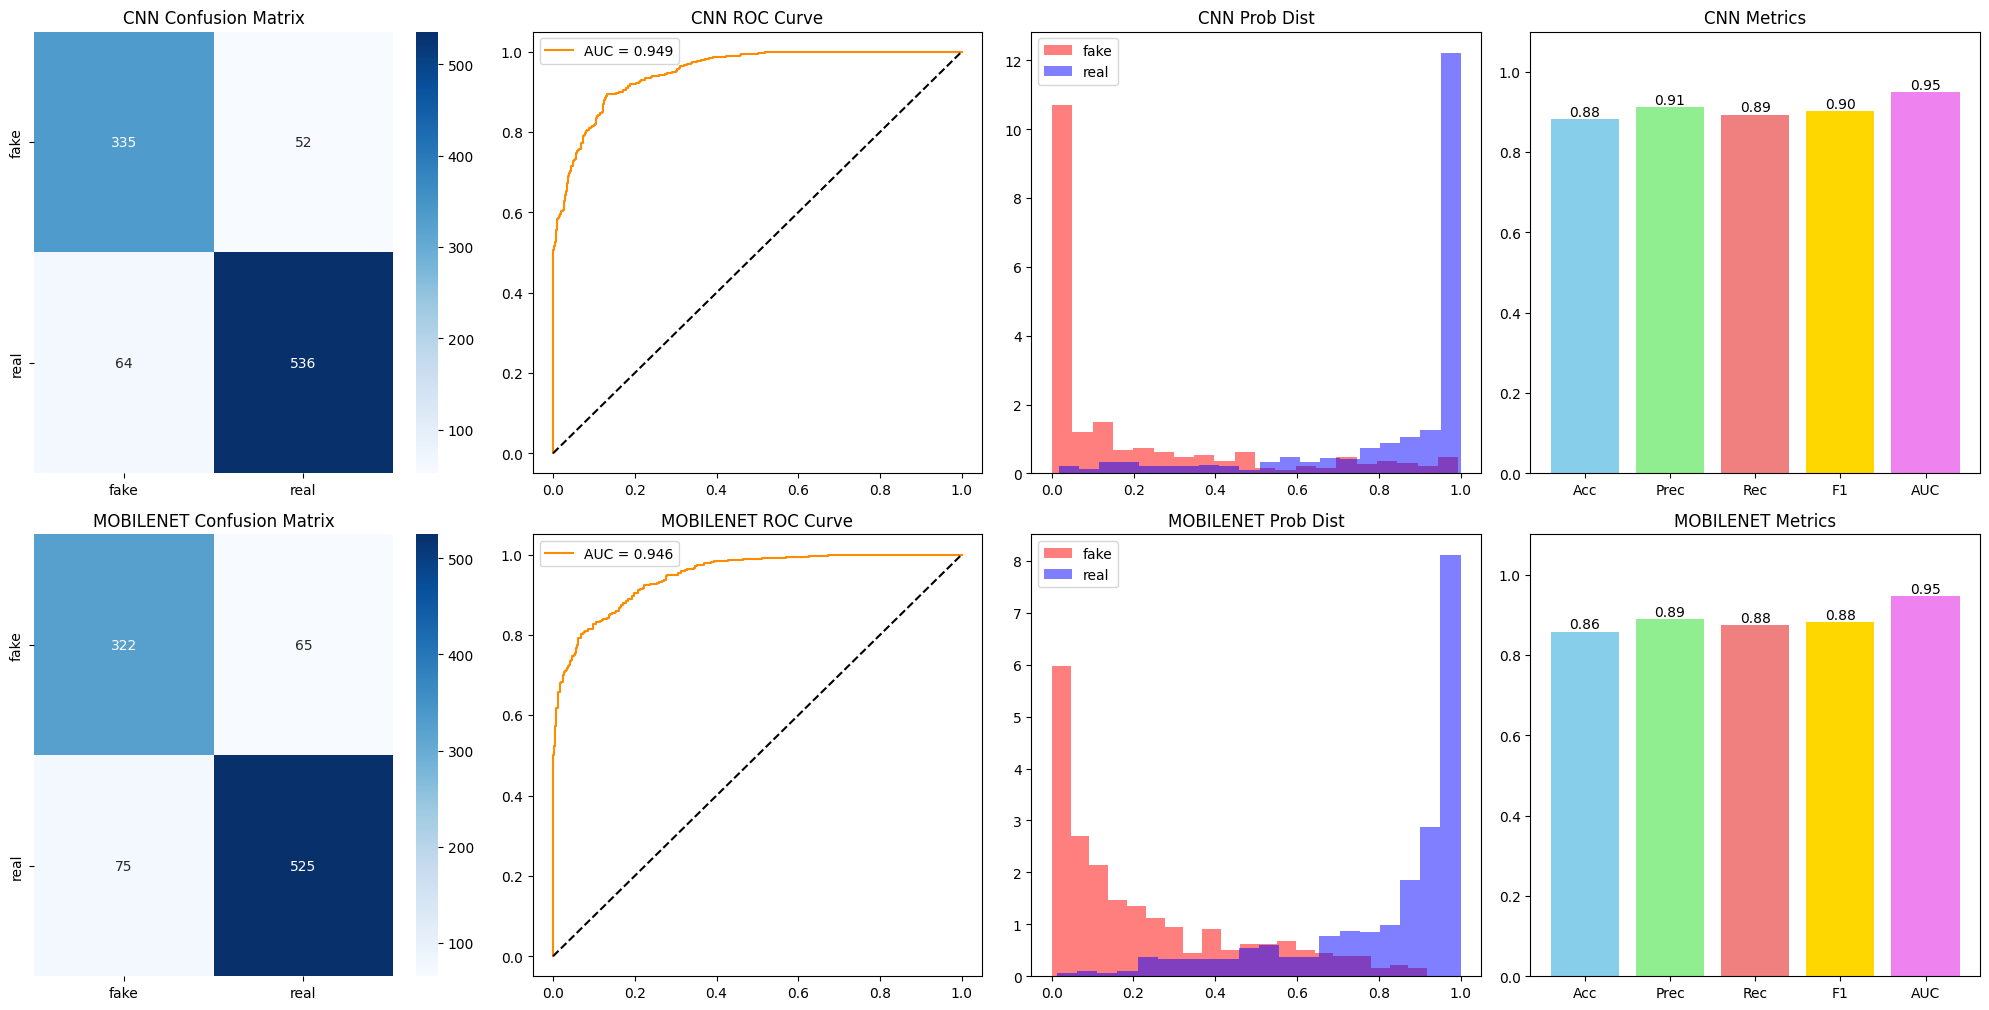

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    y_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            preds = (probs > 0.5).astype(int)

            y_true.extend(labels.numpy())
            y_pred.extend(preds)
            y_probs.extend(probs)

    return np.array(y_true), np.array(y_pred), np.array(y_probs)

# Run evaluation
metrics_summary = {}

plt.figure(figsize=(20, 15))

for idx, (name, model) in enumerate(trained_models.items()):
    print(f"Evaluating {name}...")
    y_true, y_pred, y_probs = evaluate_model(model, dataloaders['test'])

    # Metrics
    acc = np.mean(y_true == y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = tp / (tp + fp) if (tp+fp) > 0 else 0
    recall = tp / (tp + fn) if (tp+fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision+recall) > 0 else 0
    auc_score = roc_auc_score(y_true, y_probs)

    metrics_summary[name] = {
        'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc_score
    }

    # 1. Confusion Matrix
    plt.subplot(3, 4, idx * 4 + 1)
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name.upper()} Confusion Matrix')

    # 2. ROC Curve
    plt.subplot(3, 4, idx * 4 + 2)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {auc_score:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{name.upper()} ROC Curve'); plt.legend()

    # 3. Probability Hist
    plt.subplot(3, 4, idx * 4 + 3)
    plt.hist(y_probs[y_true==0], bins=20, alpha=0.5, label=class_names[0], color='red', density=True)
    plt.hist(y_probs[y_true==1], bins=20, alpha=0.5, label=class_names[1], color='blue', density=True)
    plt.title(f'{name.upper()} Prob Dist'); plt.legend()

    # 4. Metrics Bar
    plt.subplot(3, 4, idx * 4 + 4)
    vals = [acc, precision, recall, f1, auc_score]
    names = ['Acc', 'Prec', 'Rec', 'F1', 'AUC']
    bars = plt.bar(names, vals, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'violet'])
    plt.title(f'{name.upper()} Metrics'); plt.ylim(0, 1.1)
    for bar, v in zip(bars, vals):
         plt.text(bar.get_x() + bar.get_width()/2, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 🏆 Cell 10: Final Comparison

This prints a clean table comparing the two models. **bold text**

In [ ]:
import pandas as pd

print("\n" + "="*40)
print("FINAL MODEL COMPARISON")
print("="*40)

df_results = pd.DataFrame(metrics_summary).T
print(df_results.round(4))

best_model_name = df_results['Accuracy'].idxmax()
print(f"\n🏆 Best Model: {best_model_name.upper()} with Accuracy: {df_results.loc[best_model_name, 'Accuracy']:.4f}")


FINAL MODEL COMPARISON
           Accuracy  Precision  Recall      F1     AUC
cnn          0.8825     0.9116  0.8933  0.9024  0.9487
mobilenet    0.8582     0.8898  0.8750  0.8824  0.9464

🏆 Best Model: CNN with Accuracy: 0.8825


### 🔮 Cell 11: Single Image Prediction

Test a completely new image to see if it is Real or Fake. **bold text**

In [ ]:
CNN_PATH = "/content/drive/MyDrive/Model_Weights/CustomCNN_DeepFake_Detector_best.pth"
cnn_model = CustomCNN()
cnn_model.load_state_dict(torch.load(CNN_PATH, map_location=device))
cnn_model.to(device)
cnn_model.eval()

print("✅ CustomCNN loaded successfully and ready for inference.")

✅ CustomCNN loaded successfully and ready for inference.


### Cell **12**

In [ ]:
MOB_PATH = "/content/drive/MyDrive/Model_Weights/MobileNetV2_DeepFake_Detector_best.pth"
mobilenet_model = create_mobilenet()
mobilenet_model.load_state_dict(torch.load(MOB_PATH, map_location=device))
mobilenet_model.to(device)
mobilenet_model.eval()

print("✅ MobileNetV2 loaded successfully and ready for inference.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ MobileNetV2 loaded successfully and ready for inference.


### Cell **13**

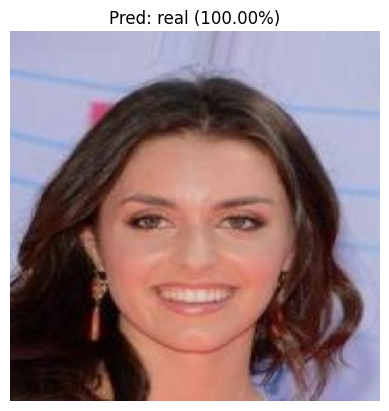

In [ ]:
from PIL import Image

def predict_single_image(model, image_path):
    model.eval()

    # Load and transform
    img = Image.open(image_path).convert('RGB')
    img_t = data_transforms['test'](img).unsqueeze(0).to(device) # Add batch dim

    with torch.no_grad():
        output = model(img_t)
        prob = torch.sigmoid(output).item()
        pred_idx = 1 if prob > 0.5 else 0

    prediction = class_names[pred_idx]
    confidence = prob if pred_idx == 1 else 1 - prob

    plt.imshow(img)
    plt.title(f"Pred: {prediction} ({confidence:.2%})")
    plt.axis('off')
    plt.show()

# Example Usage (Replace path)
predict_single_image(trained_models['cnn'], '/content/drive/MyDrive/Dataset2/test/real/03.jpg')